In [332]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-02T11:16:05.899 (PT)


In [333]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [334]:
# Import Libraries
using Turing
using Turing: Variational
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using JSON3
using PyPlot
using StatsFuns
import Random
import StatsBase.countmap
include(joinpath(@__DIR__, "../util/BnpUtil.jl"));

In [335]:
# Directory where all simulation data are stored.
data_dir = joinpath(@__DIR__, "../../data/sim-data")
# path_to_data = joinpath(data_dir, "gmm-data-n50.json")
path_to_data = joinpath(data_dir, "gmm-data-n200.json")

# Load data in JSON format.
data = let
    x = open(f -> read(f, String), path_to_data)
    JSON3.read(x, Dict{Symbol, Vector{Any}})
end

Dict{Symbol,Array{Any,1}} with 5 entries:
  :w        => Any[0.220078, 0.291918, 0.2498, 0.238204]
  :mu       => Any[-1.47027, -0.46176, 0.440237, 1.49896]
  :sig      => Any[0.148861, 0.121097, 0.195192, 0.19999]
  :y        => Any[-0.643664, -0.506898, -0.616358, -1.37424, -0.230964, -1.706…
  :rand_idx => Any[2, 2, 2, 1, 2, 1, 4, 4, 2, 4  …  3, 2, 4, 1, 3, 4, 2, 2, 2, …

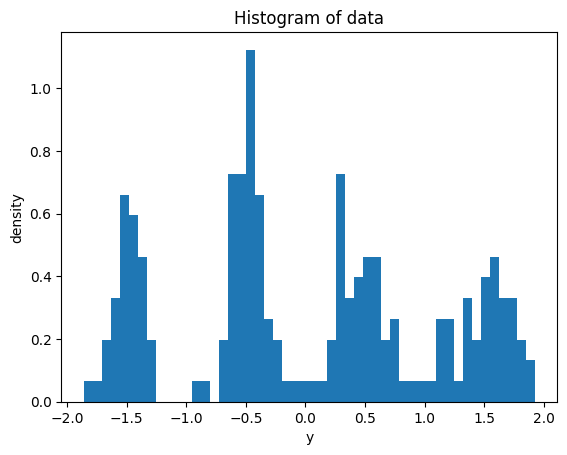

In [336]:
# Convert data to vector of floats
y = Float64.(data[:y]);

# Visualize data
plt.hist(y, bins=50, density=true)
plt.xlabel("y")
plt.ylabel("density")
plt.title("Histogram of data");

In [338]:
function counts_plot(x; density=false, color="C0", lw=4)
    cm_x = countmap(x)
    number = collect(keys(cm_x))
    count = let
        c = collect(values(cm_x))
        density ? c / sum(c) : c
    end
    plt.vlines(number, 0, count, color=color, lw=lw)
end

counts_plot (generic function with 1 method)

In [339]:
# DP GMM model under CRP construction
@model dp_gmm_crp(y) = begin
    nobs = length(y)
    
    alpha ~ Gamma(1, 0.1)  # mean = a*b
    rpm = DirichletProcess(alpha)
    
    # Base measure.
    H = arraydist([Normal(0, 3), InverseGamma(2, 0.05)])
    
    # Latent assignment.
    z = tzeros(Int, nobs)
    
    # Locations and scales of infinitely many clusters.
    mu_sigma = TArray(Vector{Float64}, 0)
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        n = Vector{Int}([sum(z .== k) for k in 1:K])
        
        # Sample cluster label.
        z[i] ~ ChineseRestaurantProcess(rpm,  n)
        
        # Create a new cluster.
        if z[i] > K
            push!(mu_sigma, [0.0, 0.1])
            mu_sigma[z[i]] ~ H
        end
        
        # Sampling distribution.
        mu, sigma = mu_sigma[z[i]]
        y[i] ~ Normal(mu, sigma)
    end
end
;

In [340]:
# Set random seed for reproducibility
Random.seed!(0);

# Compile time approx. 32s.
# Run time approx. 70s

@time chain = begin
    burn = 2000  # NOTE: The burn in is also returned. Discard manually.
    n_samples = 1000
    iterations = burn + n_samples

    sample(dp_gmm_crp(y), SMC(), iterations)
    # sample(dp_gmm_crp(y), IS(), iterations)
    # sample(dp_gmm_crp(y), Gibbs(PG(5, :z), PG(5, :mu_sigma)), iterations)
    # sample(dp_gmm_crp(y), PG(10), iterations)
end;

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


315.946609 seconds (778.06 M allocations: 32.200 GiB, 5.55% gc time)


In [341]:
chain.name_map
chain.value
# mean(chain[:mu_sigma].value.data[:, [1,3,5,7,9,11], 1], dims=1)

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 1:1:3000
    :var, ["alpha", "le", "lp", "mu_sigma[1][1]", "mu_sigma[1][2]", "mu_sigma[2][1]", "mu_sigma[2][2]", "weight", "z[1]", "z[2]"  …  "z[191]", "z[192]", "z[193]", "z[194]", "z[195]", "z[196]", "z[197]", "z[198]", "z[199]", "z[200]"]
    :chain, 1:1
And data, a 3000×208×1 Array{Float64,3}:
[:, :, 1] =
 0.0076696  -316.039  0.0  -0.611196  …  2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  1.0  2.0  2.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  2.0  1.0  1.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  2.0  1.0  2.0
 0.0076696  -316.039  0.0  -0.611196  …  2.0  2.0  2.0  2.0  2.0  2.0  1.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  2.0  2.0  2.0
 0.0076696  -316.039  0.0  -0.611196     2.0  2.0  2.0  2.0  1.0  2.0  2.0
 0.0076696  -316.039  0.0  -

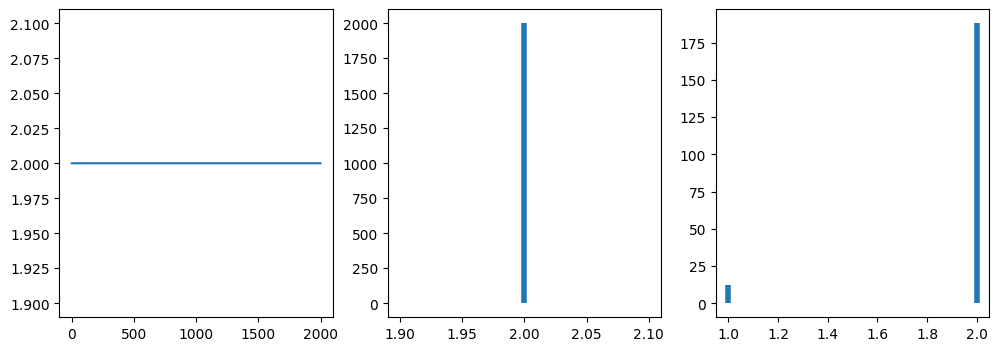

In [342]:
z = chain.value.data[end-burn+1:end, (end-length(y)+1):end, 1]
nclus = [length(unique(z[i, :])) for i in 1:size(z, 1)];
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.plot(nclus);
plt.subplot(1, 3, 2)
counts_plot(nclus);
plt.subplot(1, 3, 3)
counts_plot(z[end, :]);

In [345]:
# chain.value.data[:, 4:10, 1]

In [344]:
# exp_num_clus(a, n) = a * log1p(n / a)
# counts_plot(rand(Poisson(exp_num_clus(1.0, 200)), 100000), density=true);